# **Importing required libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
import pickle

# Loading & Splitting the data

In [4]:
df = pd.read_csv('train.csv')
df.tail()

,latitude,longitude,year,season_categorical,pricetype_binary,month_categorical,commodities_categorical,adjusted_price,month_sin,month_cos
64216,13.062665,11.171371,2023,2,1,6,31,224.488083,1.220000e-16,-1.0
64217,13.062665,11.171371,2023,2,1,6,35,203.507889,1.220000e-16,-1.0
64218,13.062665,11.171371,2023,2,1,6,36,139.866566,1.220000e-16,-1.0
64219,13.062665,11.171371,2023,2,1,6,39,15.105740,1.220000e-16,-1.0
64220,13.062665,11.171371,2023,2,1,6,37,9.431097,1.220000e-16,-1.0


In [5]:
# Split data into features and target
X = df.drop(columns=['adjusted_price'])
y = df['adjusted_price']

# Split the data into a training set and a test set (e.g., 80% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

# Modeling- **RandomForestRegressor**

In [15]:
#Getting all the columns
num_features = list(X.columns)
numeric_features = num_features

# Create a column transformer to apply standardization to numeric features
numeric_transformer = StandardScaler()

# Combine transformers using the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Define the hyperparameters and their possible values
param_grid = {
    'regressor__n_estimators': [50, 75, 100],  # Number of trees in the forest
    'regressor__max_depth': [None, 6, 13],  # Maximum depth of the trees
}
# Pipeline to automate the preprocessing
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Initialize the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator from the grid search
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# View the best parameters
print(f'Best Parameters: {best_params}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'regressor__max_depth': None, 'regressor__n_estimators': 100}


# Evaluation Metrics

In [6]:
y_pred = loaded_model.predict(X_test)
y_pred_train = loaded_model.predict(X_train)

# Calculate (MAE),(R2),(MSE) score for training data
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)

# Calculate (MAE),(R2),(MSE) score for test data
mae1 = mean_absolute_error(y_test, y_pred)
mse1 = mean_squared_error(y_test, y_pred)
rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
r21 = r2_score(y_test, y_pred)

# Create a dataframe for evaluation metrics
metrics_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'R2 Score'],
    'Train': [mae, mse, rmse, r2],
    'Test': [mae1, mse1, rmse1, r21]
}
metrics_df = pd.DataFrame(metrics_data)
# Print the dataframe
metrics_df

,Metric,Train,Test
0,MAE,34.628450,48.793197
1,MSE,199874.204113,297699.529986
2,RMSE,447.072929,545.618484
3,R2 Score,0.987746,0.985586


# Visualizing & Testing the model with **KNOWN** & **UNKNOWN** data

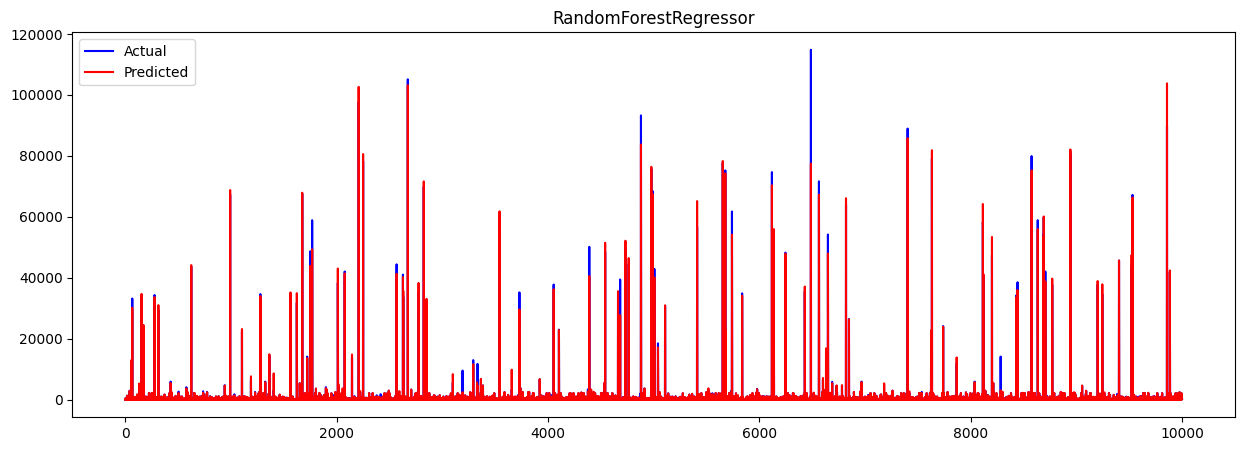

In [7]:
# Visualizing the predictions with known data
plt.figure(figsize=(15, 5))
plt.plot(y_test[0:10000].values, color='blue', label='Actual')
plt.plot(y_pred[0:10000], color='red', label='Predicted')
plt.title('RandomForestRegressor')
plt.legend()
plt.show();

# Saving the model

In [23]:
pickle.dump(best_estimator,open('model.pkl','wb'))

# Testing with **UNKNOWN** dataset

In [10]:
# Load the model
with open('abhinash_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [11]:
# Loading test.csv
test_data = pd.read_csv("evaluate.csv")
data = test_data.drop(columns=['adjusted_price'])
data.tail()

,latitude,longitude,year,season_categorical,pricetype_binary,month_categorical,commodities_categorical,month_sin,month_cos
2,12.362300,9.583600,2023,0,0,1,6,0.500000,8.660254e-01
3,12.496693,11.499503,2023,0,1,2,23,0.866025,5.000000e-01
4,11.285202,11.999501,2023,1,1,3,40,1.000000,6.120000e-17
5,11.834551,13.152417,2023,1,1,4,32,0.866025,-5.000000e-01
6,11.858182,13.154892,2023,1,1,5,31,0.500000,-8.660254e-01


In [16]:
test_data['adjusted_price']

0      275.782714
1    43753.664660
2      188.821752
3       15.944948
4      275.260154
5       22.378874
6       16.784156
Name: adjusted_price, dtype: float64

In [23]:
actual_data = test_data['adjusted_price']
predicted_result = loaded_model.predict(data)

outcome_data = {
    'Actual Price': actual_data.values,  # Use .values to get the value from the pandas series
    'Predicted Price': predicted_result.flatten()  # Use flatten to convert the result to a 1D array
}

outcome_df = pd.DataFrame(outcome_data)

# Print the dataframe
outcome_df

,Actual Price,Predicted Price
0,275.782714,269.923459
1,43753.664660,37928.936156
2,188.821752,190.466626
3,15.944948,17.899251
4,275.260154,235.850957
5,22.378874,22.799474
6,16.784156,16.848555
